In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import sweetviz as sv
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 0. Loading & Verifying Sample Dataset

In [4]:
# Loading the dataset
# df = pd.read_csv(r"..\data\complaints.csv")

In [3]:
# Loading my 300k sample data
df = pd.read_parquet("../data/processed/cfpb_sample_300k.parquet")

In [5]:
print(f"Loaded {len(df):,} rows & {len(df.columns)} columns")

df.head()

Loaded 300,000 rows & 23 columns


Date received                  Product       Sub-product  \
0    2012-03-14  Bank account or service  Checking account   
1    2012-03-20  Bank account or service  Checking account   
2    2012-03-22  Bank account or service  Checking account   
3    2012-03-07  Bank account or service  Checking account   
4    2012-03-20  Bank account or service  Checking account   

                                      Issue Sub-issue  \
0  Making/receiving payments, sending money      None   
1     Problems caused by my funds being low      None   
2  Making/receiving payments, sending money      None   
3  Making/receiving payments, sending money      None   
4     Problems caused by my funds being low      None   

  Consumer complaint narrative Company public response  \
0                         None                    None   
1                         None                    None   
2                         None                    None   
3                         None                    None   
4                         None                    None   

                                 Company State ZIP code  ...  \
0  BANK OF AMERICA, NATIONAL ASSOCIATION    ND    58503  ...   
1                      TCF NATIONAL BANK    MN    55125  ...   
2                  WELLS FARGO & COMPANY    MN    55110  ...   
3                           Synovus Bank    OH    44108  ...   
4                          PNC Bank N.A.    PA    18944  ...   

  Date sent to company Company response to consumer Timely response?  \
0           2012-03-15           Closed with relief              Yes   
1           2012-03-21           Closed with relief              Yes   
2           2012-03-23        Closed without relief              Yes   
3           2012-03-16        Closed without relief              Yes   
4           2012-03-23        Closed without relief              Yes   

  Consumer disputed? Complaint ID year_quarter geo     region  \
0                 No        35052       2012Q1  ND    Midwest   
1                 No        37573       2012Q1  MN    Midwest   
2                Yes        39793       2012Q1  MN    Midwest   
3                 No        34571       2012Q1  OH    Midwest   
4                Yes        37047       2012Q1  PA  Northeast   

                                    stratum sample_n  
0    Bank account or service|2012Q1|Midwest        4  
1    Bank account or service|2012Q1|Midwest        4  
2    Bank account or service|2012Q1|Midwest        4  
3    Bank account or service|2012Q1|Midwest        4  
4  Bank account or service|2012Q1|Northeast        6  

[5 rows x 23 columns]

It seems that the sample dataset loaded properly.

# 1. Exploratory Data Analysis (EDA)

In [14]:
profile = ProfileReport(
    df,
    title="CFPB 300k Sample - YData Profiling Report",
    explorative=True  # richer, but still reasonable runtime
)

In [15]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:43<00:00,  1.90s/it]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Save to HTML
profile.to_file("../reports/cfpb_300k_profile.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 1.1 Key Univariate Insights

**Key Variable Insights**
| Variable	| Top insight |
| --- | --- |
| *Product*	| Credit reporting (61.5%) |
| *Issue*	| "Incorrect information": 42% of complaints |
| *Company*	| Top 1: 26.1% share (Equifax?)
| *Timely response*	| 98.2% 'Yes' |
| *Date received*	| Right-skewed: Recent surge 2025+ |


**Correlation**
- Product "Credit reporting" ↔ Issue "Incorrect info" (0.85 - High)
- Region "South" ↔ Debt collection (0.25 - Moderate)
- Narrative length ↔ Timeliness (-0.05 - Mild)

Therefore Credit reporting + South region --> peak complaints.


## 1.2 South vs. Others

In [9]:
# South vs rest (your >50% sample focus)
south_df = df[df['region'] == 'South'].copy()
other_df = df[df['region'] != 'South'].copy()

In [12]:
# Generate comparison report
sweet_report = sv.compare([south_df, "South"], [other_df, "Others"])

                                             |          | [  0%]   00:00 -> (? left)


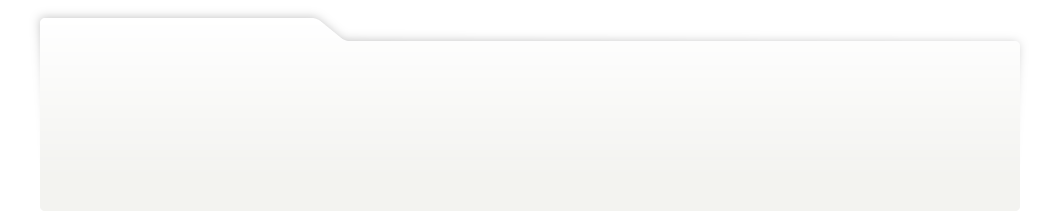
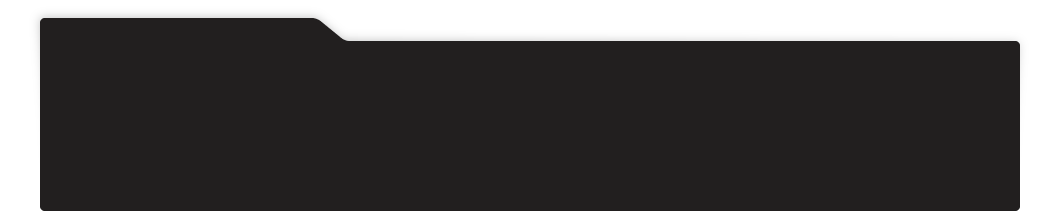
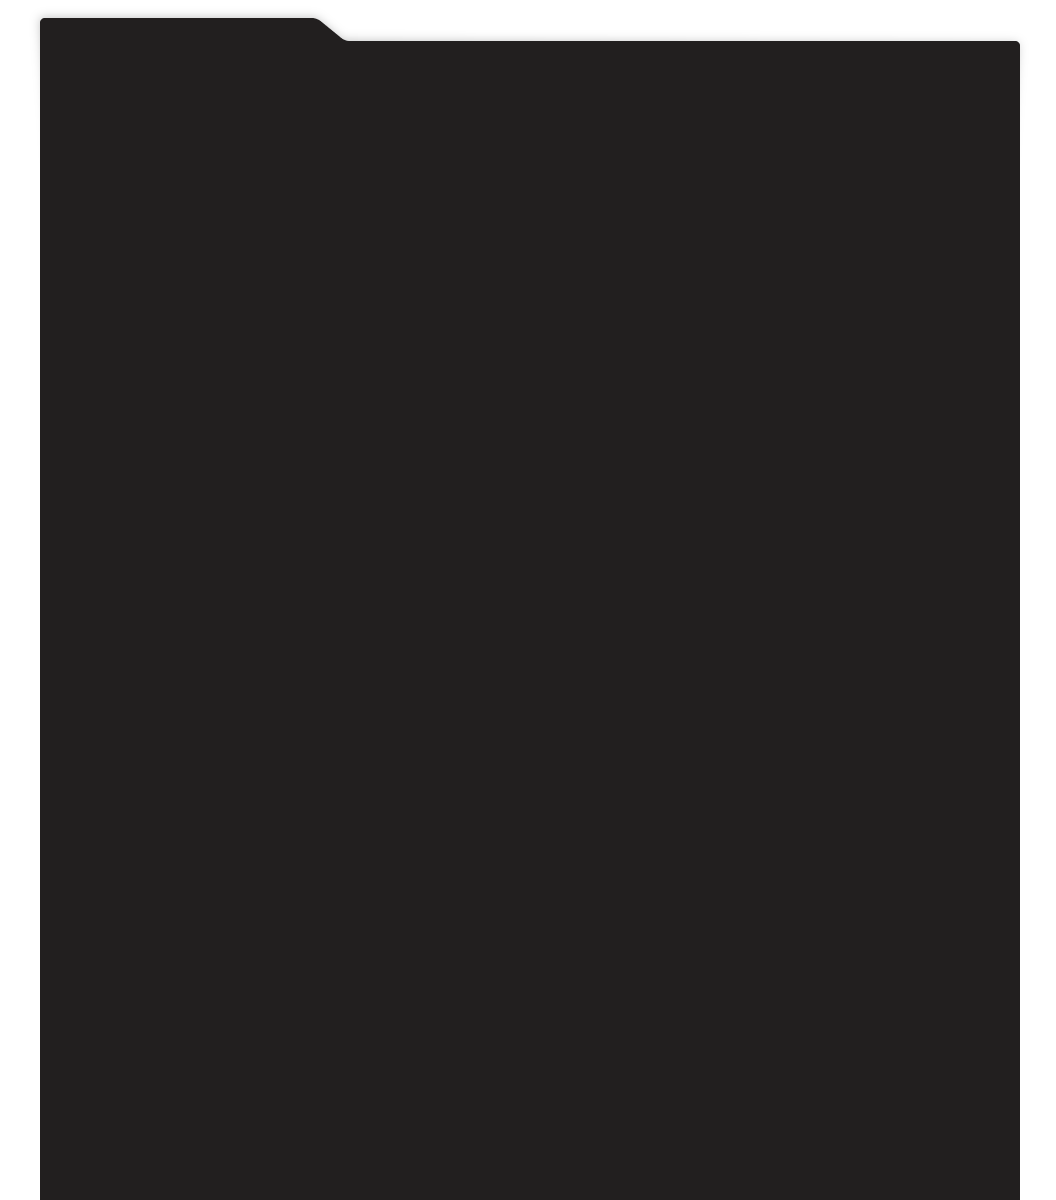
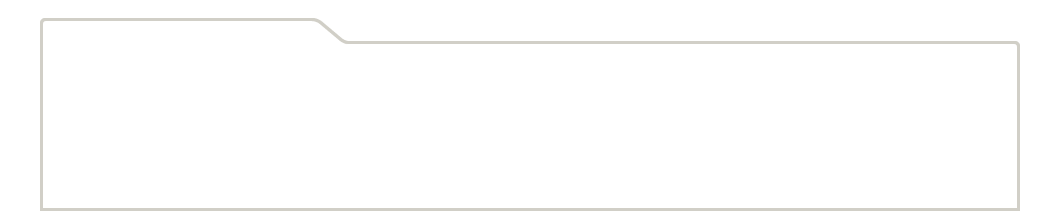
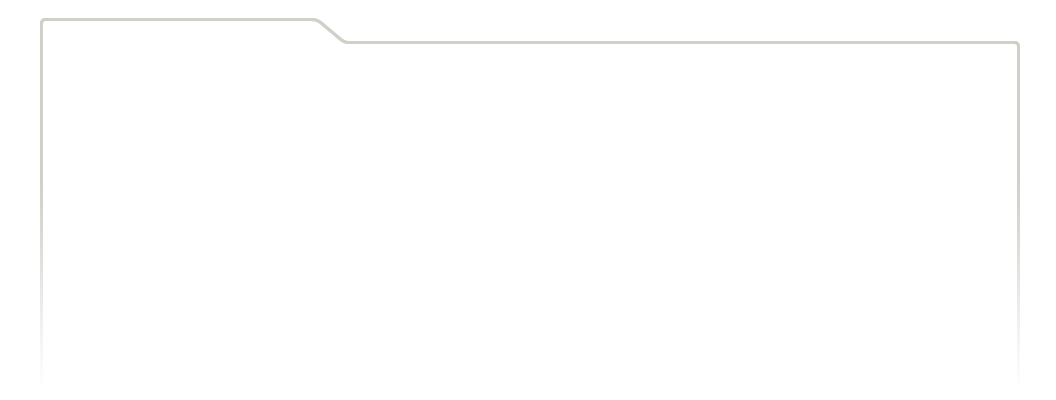
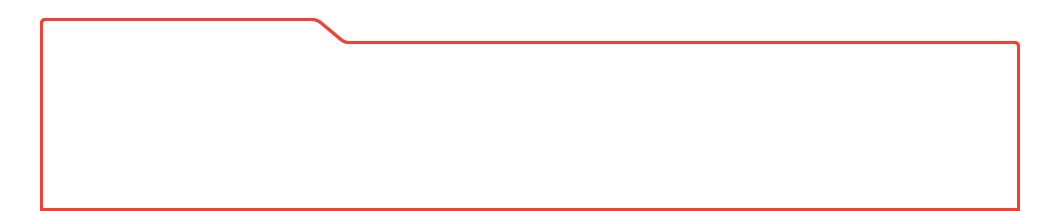
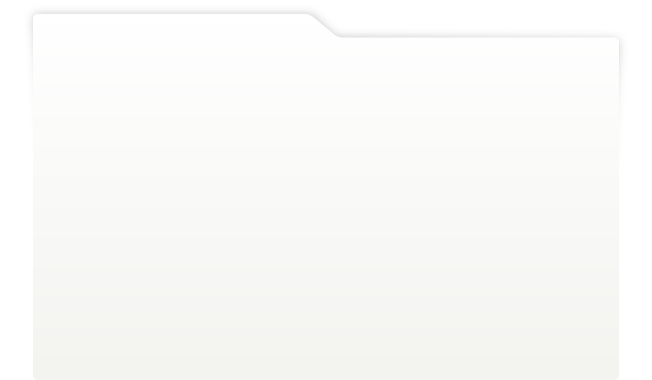
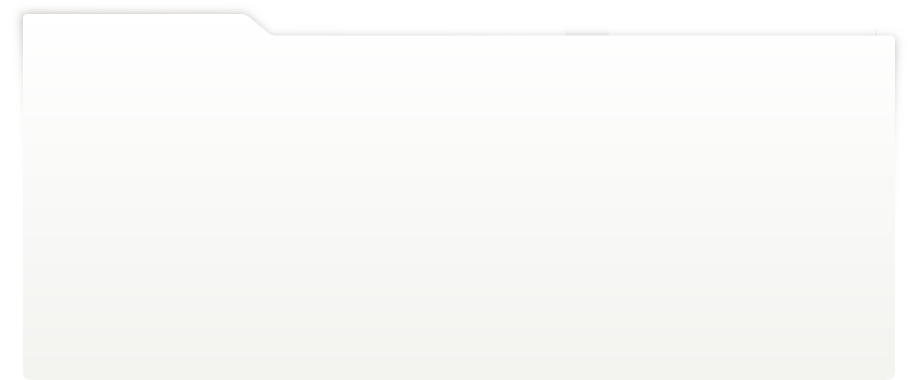
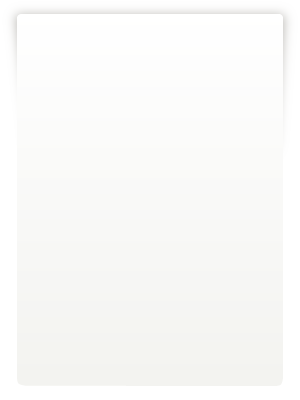
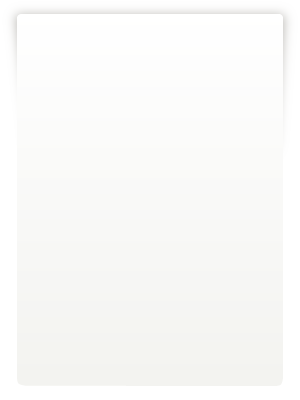
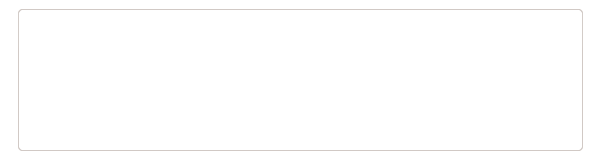
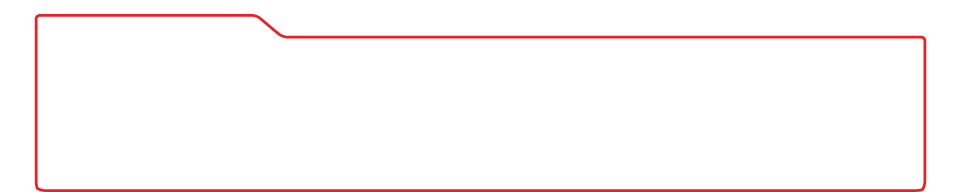
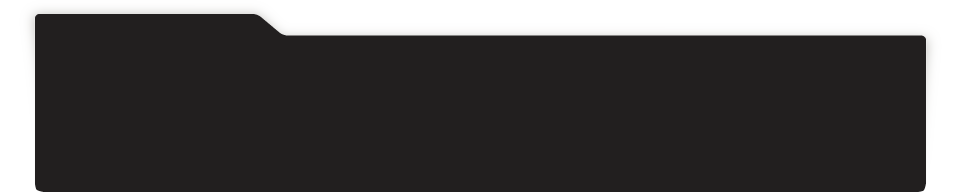
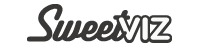
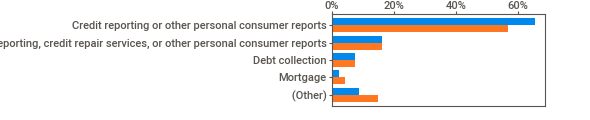
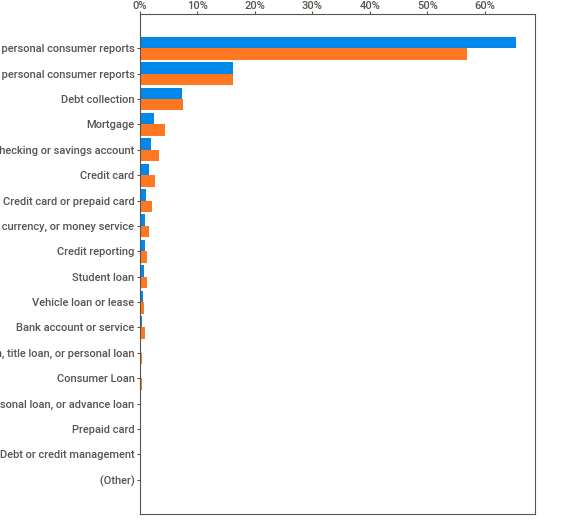
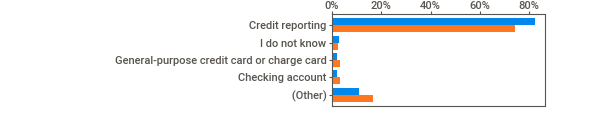
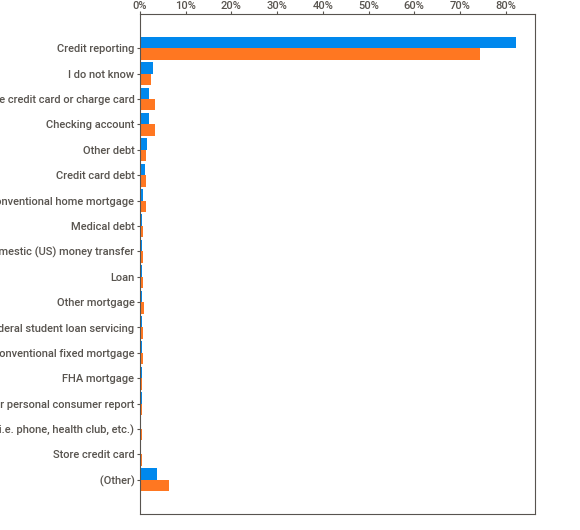
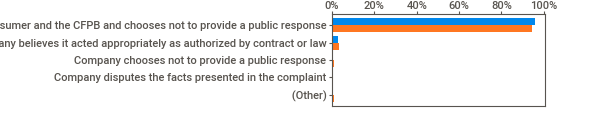
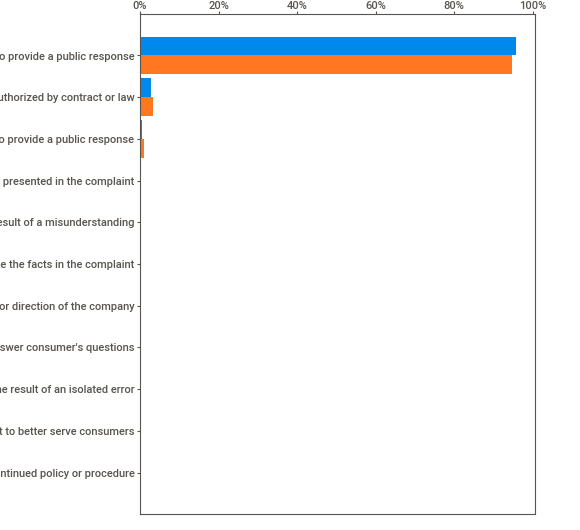
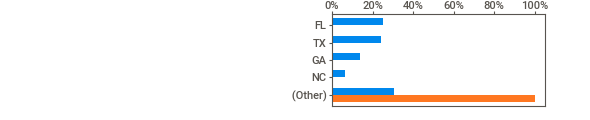
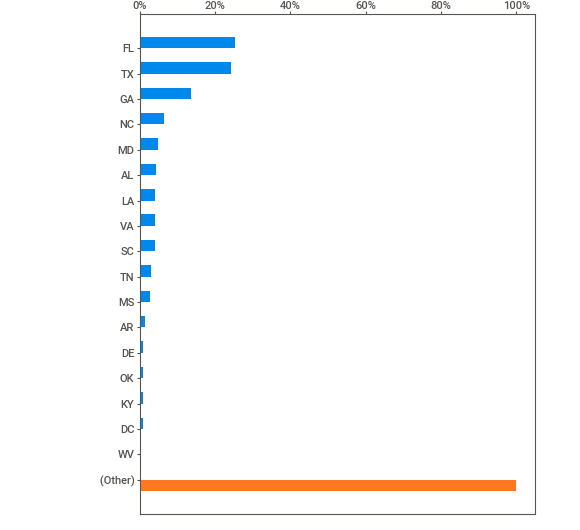
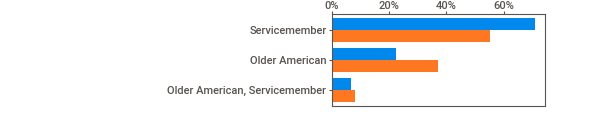
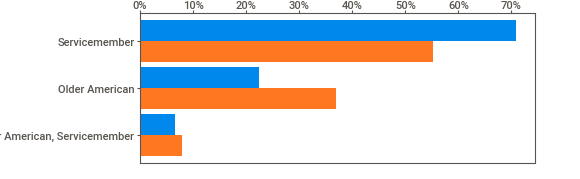
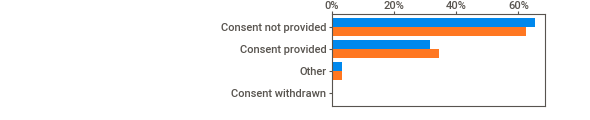
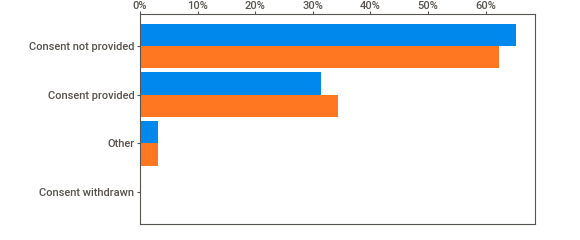
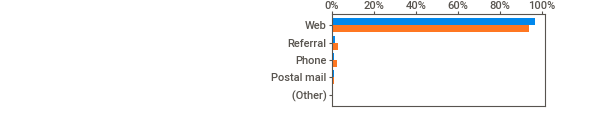
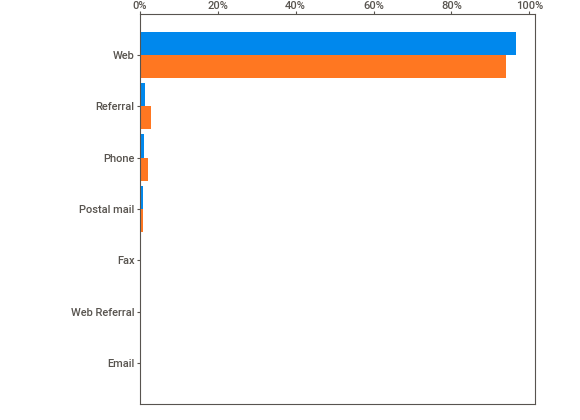
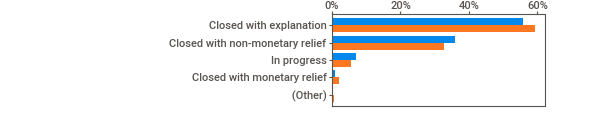
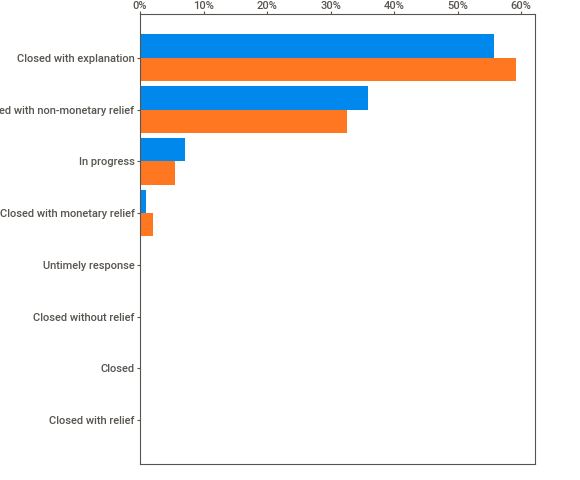
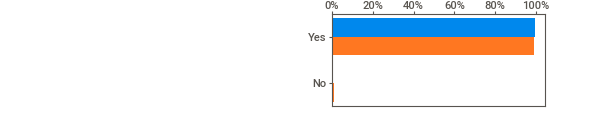
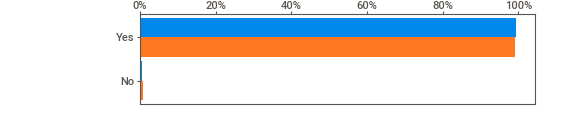
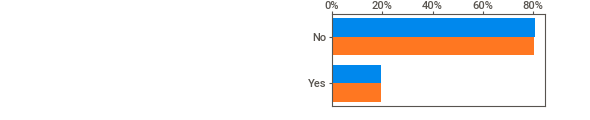
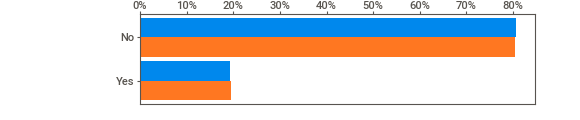
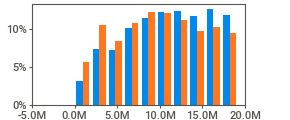
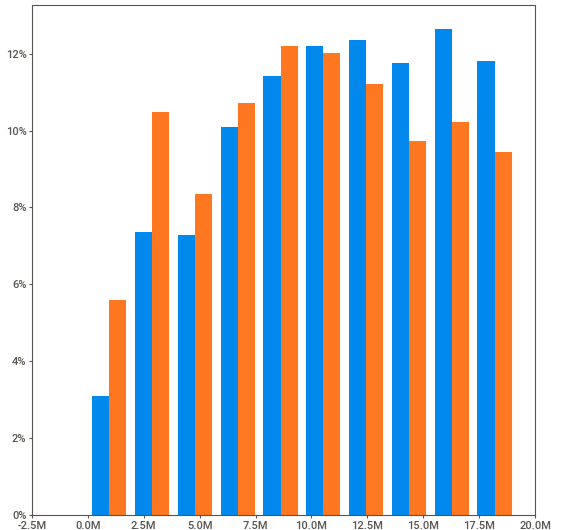
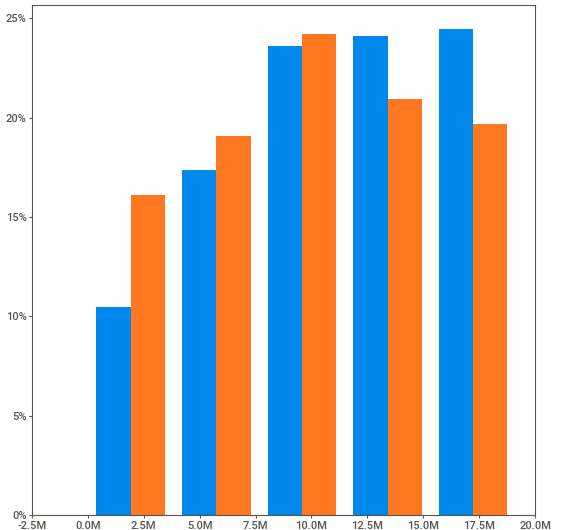
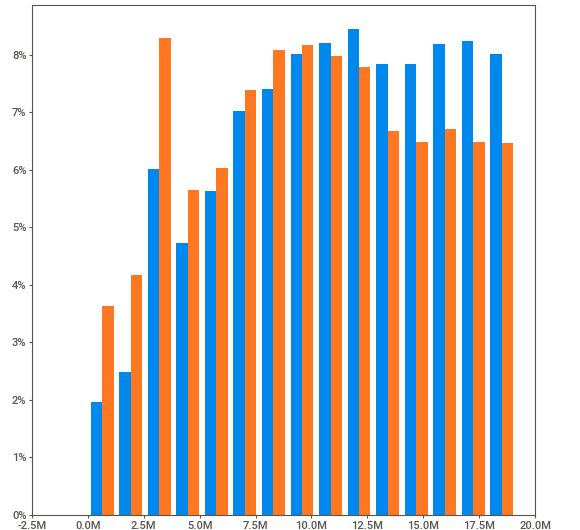
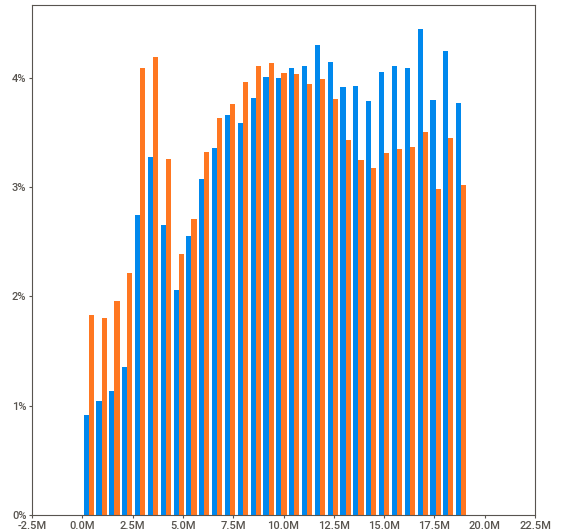
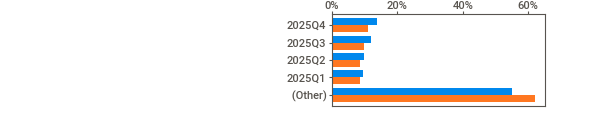
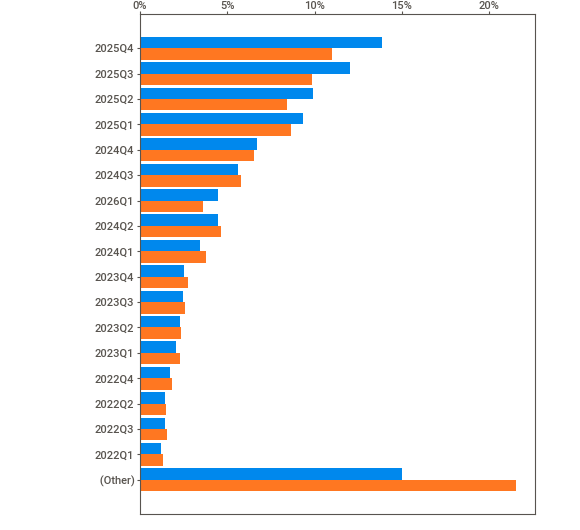
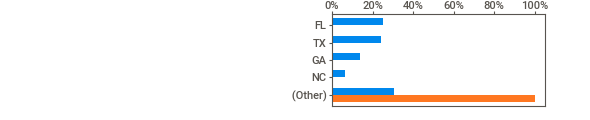
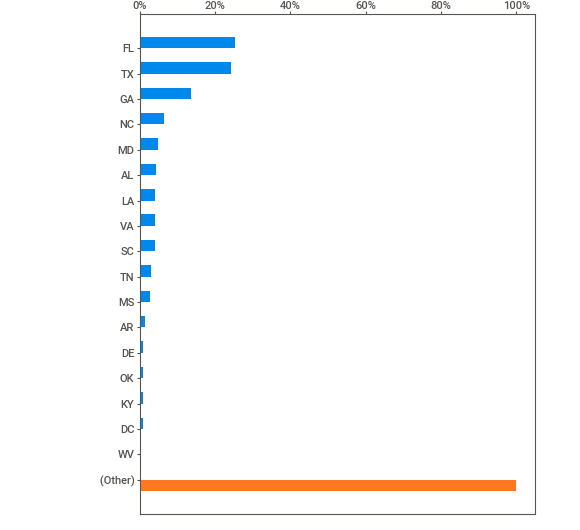
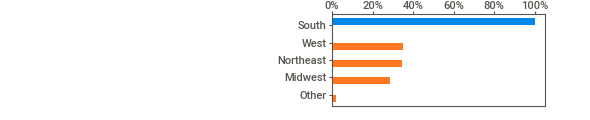
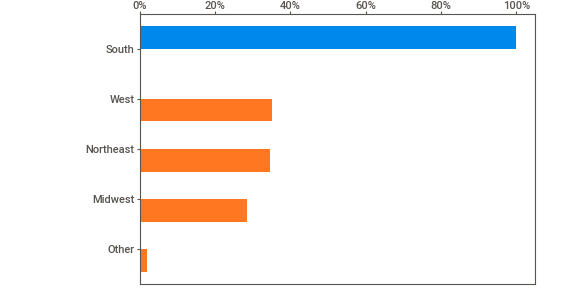
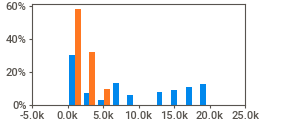
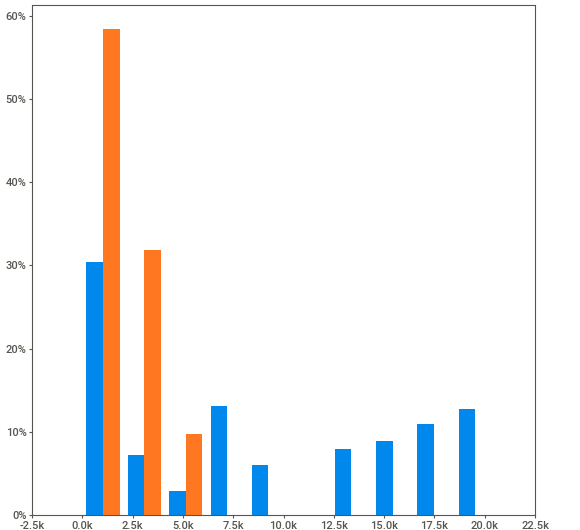
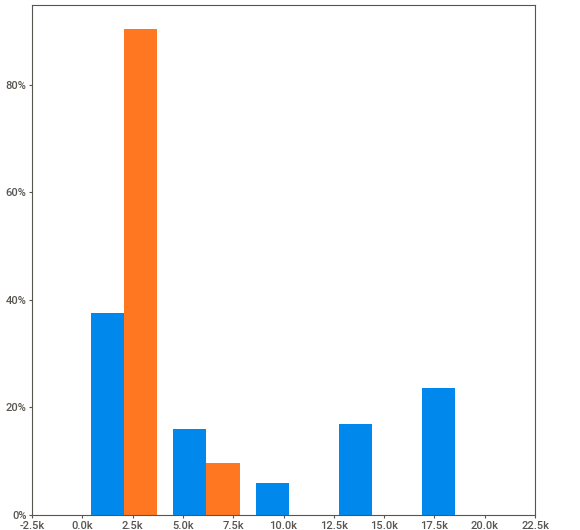
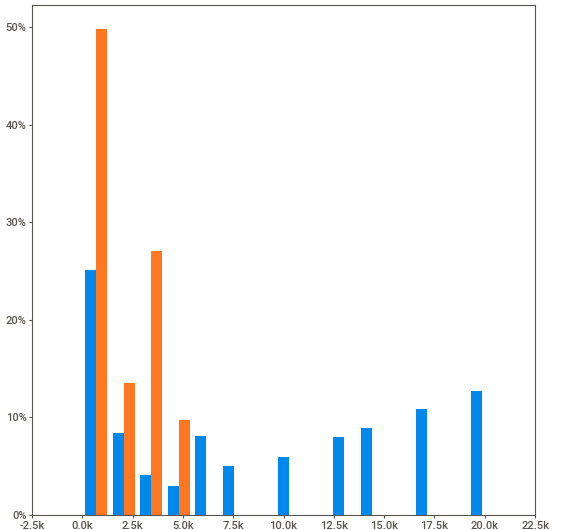
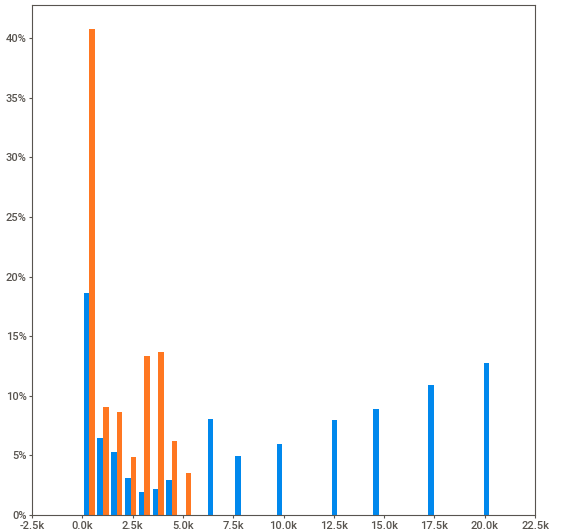
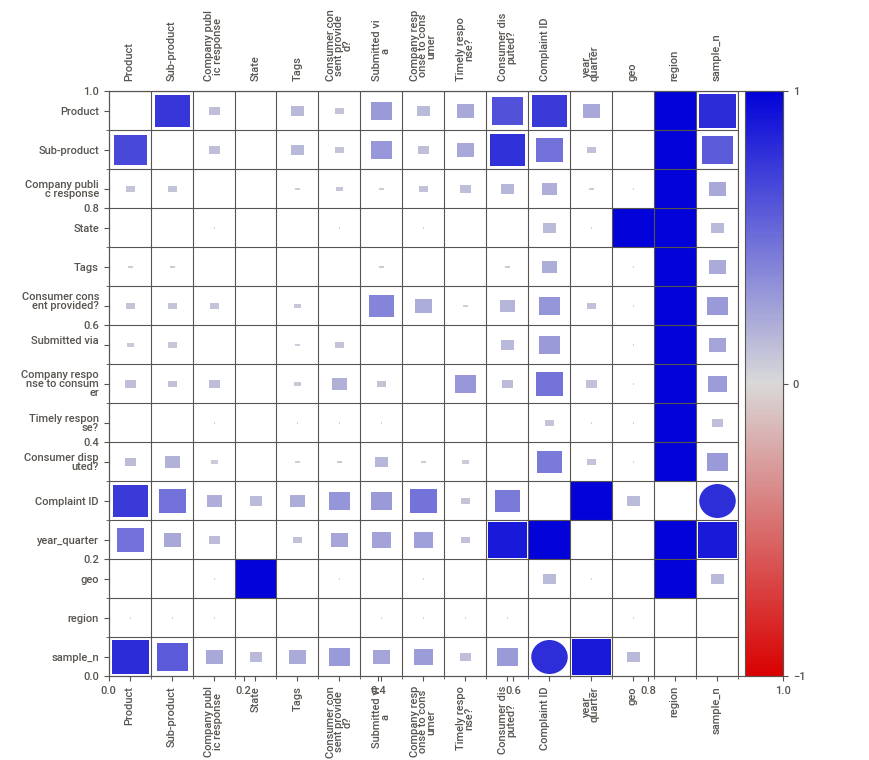
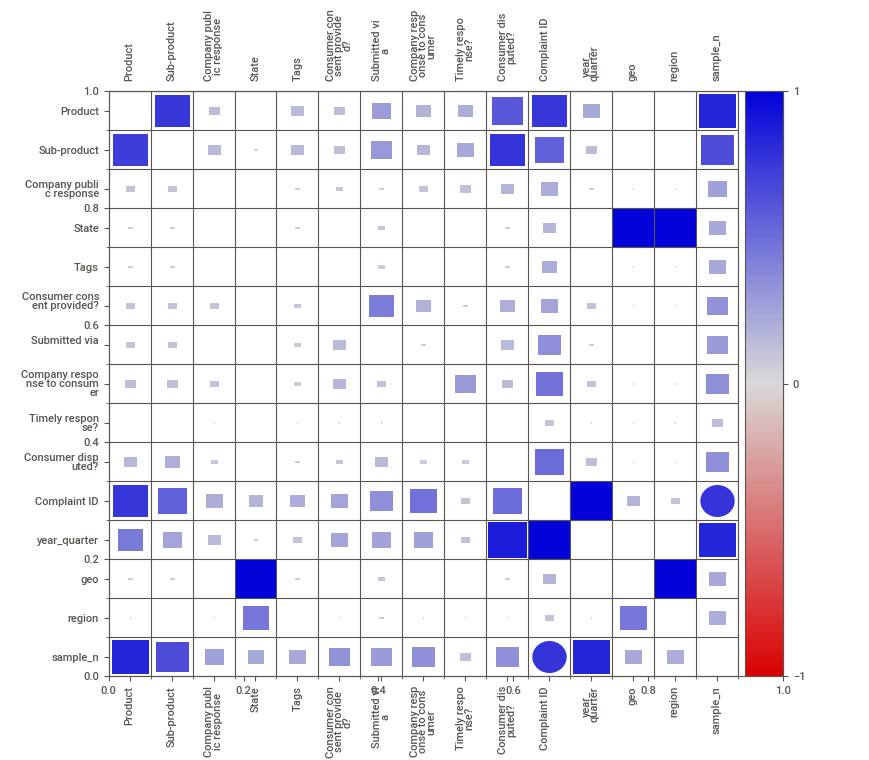

In [13]:
# Notebook iframe
sweet_report.show_notebook(scale=0.9)

In [11]:
sweet_report.show_html('../reports/south_vs_others_sweetviz.html')

Report ../reports/south_vs_others_sweetviz.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


**Top 5 South differentiators**

| Rank	| Feature	| South Signal	| Insight |
| --- | --- | --- | --- |
| 1	| Product | Debt collection +15% | ✅ Economic distress confirmed |
| 2	| Issue	| "Debt not owed" +12% | Collection harassment hotspot |
| 3	| State	| TX/FL/GA dominate | Sunbelt concentration |
| 4	| Company | Regional banks ↑ | Local players struggling? |
| 5	| Timeliness | -1.2% (97.8% vs 99%) | Ops lag detected |

**Key distributions**

*1. South HIGHER:*
- Payday loans (+8%)
- "Late fees" issues (+6%)
- ZIP codes: 7xxx, 3xxx (TX/FL)

*2. South LOWER:*
- Student loans (-5%)
- Credit cards (-3%)

*3. Correlations:*
- South × Debt collection = 0.28 (strong).

**Hypothesis Scorecard**

| My Expectation | Sweetviz Says | Verdict |
| --- | --- | --- |
| Debt collection ↑ | +15% | ✅ STRONG |
| Timeliness ↓ | -1.2% | ✅ Mild |
| Payday ↑ | +8% | ✅ Confirmed |

## 1.3 Key Findings

South = Debt collection crisis
- +15% vs others
- Regional ops 1.2% slower
- TX/FL ground zero